In [1]:
import os
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from typing import TypedDict, Literal, Optional
load_dotenv()

GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")

from langchain_google_genai import ChatGoogleGenerativeAI
model = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

f:\projects\Basic-AI-Agents\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# --- Define State Type ---
class myState(TypedDict):
    query: str 
    operation: str
    number1: int
    number2: int
    result: str

In [ ]:
# --- Define Schema for Operation Classification ---
class task_schema(BaseModel):
    task: Literal["Add", "Sub", "Div", "Mul", "Mod", "Other"]
    number1: Optional[int] = Field(..., description="First number for the operation, if operation is not 'Other'")
    number2: Optional[int] = Field(..., description="Second number for the operation, if operation is not 'Other'")

task_model = model.with_structured_output(task_schema)


In [4]:
# --- Task Detection Function ---
def find_task(state: myState) -> myState:
    prompt = (
        f"Based on the given text, identify which task the user wants to perform: "
        f"'Add', 'Sub', 'Div', 'Mul', 'Mod', or 'Other'. "
        f"Text: {state['query']}"
    )
    model_response = task_model.invoke(prompt)
    state['operation'] = model_response.task.strip().capitalize()
    if state['operation'] == 'Other':
        state['number1'] = None
        state['number2'] = None
    else:
        # Ensure number1 and number2 are predicted by the model
        state['number1'] = model_response.number1
        state['number2'] = model_response.number2
    return state

In [5]:
# --- Operation Functions ---
def Add(state: myState) -> myState:
    state['result'] = str(state['number1'] + state['number2'])
    return state

def Sub(state: myState) -> myState: 
    state['result'] = str(state['number1'] - state['number2'])
    return state

def Div(state: myState) -> myState:
    if state['number2'] == 0:
        state['result'] = "Error: Division by zero"
    else:
        state['result'] = str(state['number1'] / state['number2'])
    return state

def Mul(state: myState) -> myState:
    state['result'] = str(state['number1'] * state['number2'])
    return state

def Mod(state: myState) -> myState:
    if state['number2'] == 0:
        state['result'] = "Error: Modulo by zero"
    else:
        state['result'] = str(state['number1'] % state['number2'])
    return state


def Other(state: myState) -> myState:
    prompt = (
        f"You are a helpful assistant. "
        f"A user sent the following query: {state['query']}. "
        f"It does not match any calculator operation like Add, Sub, Div, Mul, or Mod.\n\n"
        f"Reply with a plain, friendly single-sentence answer without markdown, formatting, or multiple options."
    )
    res = model.invoke(prompt)
    state['result'] = res.content
    return state



# --- Router Function ---
def pass_state(state: myState) -> myState:
    return state

def route_decision(state: myState) -> str:
    return state["operation"]


In [6]:
# --- LangGraph ---
from langgraph.graph import StateGraph, START, END

graph = StateGraph(myState)

graph.add_node("find_task", find_task)
graph.add_node("route_task", pass_state) 

# Operation nodes
graph.add_node("Add", Add)
graph.add_node("Sub", Sub)
graph.add_node("Mul", Mul)
graph.add_node("Div", Div)
graph.add_node("Mod", Mod)
graph.add_node("Other", Other)

# Static edges
graph.add_edge(START, "find_task")
graph.add_edge("find_task", "route_task")

# Conditional edge using separate decision function
graph.add_conditional_edges("route_task", route_decision, {
    "Add": "Add",
    "Sub": "Sub",
    "Div": "Div",
    "Mul": "Mul",
    "Mod": "Mod",
    "Other": "Other"
})

# All operation nodes go to END
for op in ["Add", "Sub", "Div", "Mul", "Mod", "Other"]:
    graph.add_edge(op, END)


workflow = graph.compile()

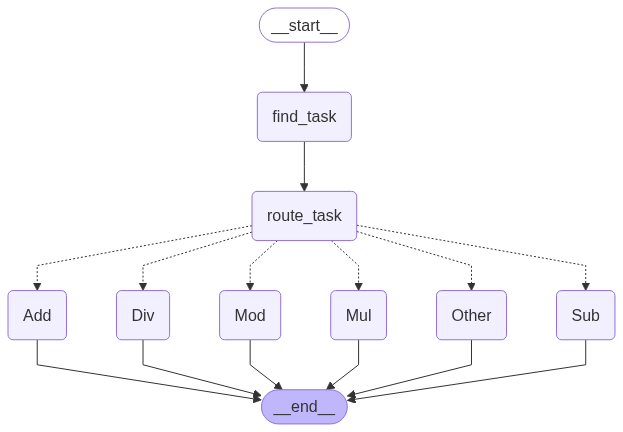

In [7]:
workflow

In [8]:
workflow.invoke({"query": "What is 5 % 5?"})

{'query': 'What is 5 % 5?',
 'operation': 'Mod',
 'number1': 5,
 'number2': 5,
 'result': '0'}

In [9]:
workflow.invoke({"query": "i want to subtract 10 from 20"})

{'query': 'i want to subtract 10 from 20',
 'operation': 'Sub',
 'number1': 20,
 'number2': 10,
 'result': '10'}

In [14]:
os.environ["LANGSMITH_PROJECT"] = "default"
workflow.invoke({"query": "I love my life"})

{'query': 'I love my life',
 'operation': 'Other',
 'number1': None,
 'number2': None,
 'result': "That's wonderful to hear!"}

In [11]:
workflow.invoke({"query": "Who are you?, and how are you?"})

{'query': 'Who are you?, and how are you?',
 'operation': 'Other',
 'number1': None,
 'number2': None,
 'result': 'I am a large language model, and I am doing well, thank you for asking.'}